⚠️ Este notebook asume que el dataset ya fue descargado y ubicado en la carpeta `data/Anxiety/` siguiendo las instrucciones del README principal.

## Configuración

In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Clonar repositorio desde GitHub (solo si no existe la carpeta local)
REPO_URL = "https://github.com/manununhez/mentalrisk-nlp-ucom.git"
REPO_NAME = "mentalrisk-nlp-ucom"

import os

if not os.path.exists(REPO_NAME):
    # Clonado rápido (solo última versión, sin historial completo)
    !git clone --depth 1 {REPO_URL}

# Cambiar al directorio del repositorio
%cd {REPO_NAME}

# 1 – Preparar el dataset

In [ ]:
# Importar librerías

import os, json, re, html, unicodedata, pathlib, warnings, itertools, pprint, joblib
import pandas as pd
import numpy as np
#from emoji import demojize                 # ←  convierte 🙂 → :slightly_smiling_face:
warnings.filterwarnings("ignore")

import sys
sys.path.append("utils")  # Asegura que Python pueda encontrar el módulo

from text_cleaning import clean_text
from data_loader import build_df_from_folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unir todos los sub-corpora

SUBSETS = {
    "Anxiety": {
        "json_dir": "/content/drive/MyDrive/data/Anxiety/data",
        "csv_path": "/content/drive/MyDrive/data/Anxiety/gold/gold_label.csv",
    },
    # descomenta / añade si tienes Depresión y TCA
    # "Depression": { … },
    # "TCA":        { … },
}

df_all_processed = pd.concat([build_df_from_folder(v["json_dir"], v["csv_path"]) for v in SUBSETS.values()], ignore_index=True)

Distribución final de etiquetas:
label
1    443
0     57
Name: count, dtype: int64


In [ ]:
# Verificar el contenido del df_all_processed

print(df_all_processed.head())
print(df_all_processed.info())
print(df_all_processed.describe())

         user  label                                      message_clean
0    subject1      1  buenos días a tod mention no sé si esta será l...
1   subject10      0  ola soi nuebo como estn a ustds los entimdm ke...
2  subject100      1  de donde son yo de perú supongo q tb sigue en ...
3  subject101      1  es lo que necesitas aaah pues perdón por no ha...
4  subject102      1  ya perdí una xd siete seguidas no está mal el ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           500 non-null    object
 1   label          500 non-null    int64 
 2   message_clean  500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB
None
           label
count  500.00000
mean     0.88600
std      0.31813
min      0.00000
25%      1.00000
50%      1.00000
75%      1.00000
max      1.00000


In [ ]:
# Guardamos a disco
csv_backup_name = 'MentalRiskES_userlevel_fasttext_clean_processed.csv'
df_all_processed.to_csv(csv_backup_name, index=False)
print(f"CSV guardado → {csv_backup_name}")


CSV consolidado → MentalRiskES_userlevel_clean_processed.csv


## Distribución de clases

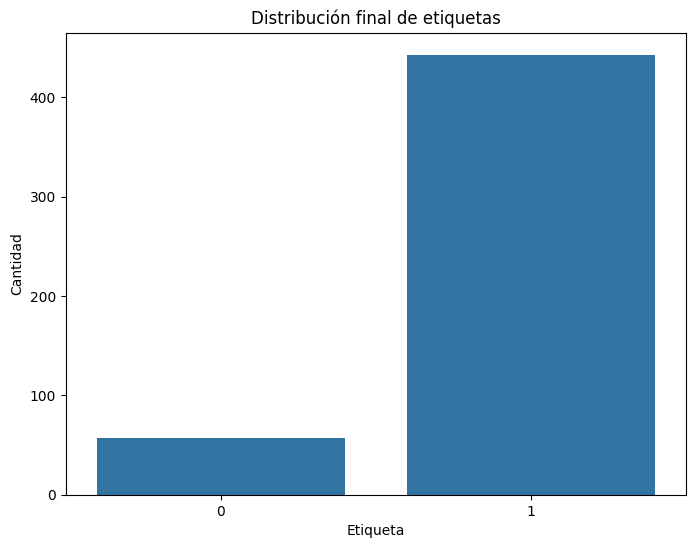

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
sns.countplot(x="label", data=df_all_processed)
plt.title("Distribución final de etiquetas")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

# 2  –  Embeddings FastText + clasificador lineal

In [ ]:
# Instalar dependencias
!pip install gensim==4.3.2 fasttext-wheel==0.9.2 imbalanced-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 17.4 MB/s eta 0:00:00


In [ ]:
# Importar librerías

import os, joblib, gzip, shutil, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import (classification_report, precision_recall_curve,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
# Cargar textos ya limpios  (CSV que generamos antes)

df = pd.read_csv(csv_backup_name)

X_temp, X_test, y_temp, y_test = train_test_split(
    df["message_clean"], df["label"],
    test_size=0.15, stratify=df["label"], random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765, stratify=y_temp, random_state=42)   # 15 % de total

In [ ]:
# Descargar y descomprimir FastText (cc.es.300.bin)

import os, pathlib, time, subprocess, textwrap, shutil
from pathlib import Path

FT_URL  = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz"
FT_GZ   = Path("/content/cc.es.300.bin.gz")
FT_BIN  = Path("/content/cc.es.300.bin")

if not FT_BIN.exists():
    print("→ Descargando modelo FastText español (~1.8 GB comprimido)…")
    t0 = time.time()
    if not FT_GZ.exists():
        # wget with progress bar
        subprocess.run(["wget", "-c", FT_URL, "-O", str(FT_GZ)], check=True)
    print("✔ Descarga completa – {:.1f} MB".format(FT_GZ.stat().st_size/1e6))

    print("→ Descomprimiendo…")
    subprocess.run(["gunzip", "-k", str(FT_GZ)], check=True)  # -k: conserva .gz
    print("✔ Descompresión lista – {:.1f} MB\nTiempo total: {:.1f} min"
          .format(FT_BIN.stat().st_size/1e6, (time.time()-t0)/60))
else:
    print("✓ cc.es.300.bin ya existe – se reutiliza")


→ Descargando modelo FastText español (~1.8 GB comprimido)…
✔ Descarga completa – 4500.1 MB
→ Descomprimiendo…
✔ Descompresión lista – 7238.8 MB
Tiempo total: 1.2 min


In [ ]:
# Cargar modelo FastText en memoria (≈30 s)

import fasttext, gc, time
t0 = time.time()
ft_model = fasttext.load_model(str(FT_BIN))       # usa mmap → RAM ≈4.3 GB
print("✔ FastText cargado – dimensión:", ft_model.get_dimension(),
      "Tiempo:", round(time.time()-t0,1), "s")

✔ FastText cargado – dimensión: 300 Tiempo: 10.5 s


In [ ]:
# Función → texto → vector  (promedio de palabras in-vocab)

from functools import lru_cache, partial
import re
TOK = re.compile(r"\w[\w_]+")
vector_size = ft_model.get_dimension() # Define vector_size globally

def word_vec(word):
    if word in ft_model.wv:
        return ft_model.wv[word]
    return np.zeros(vector_size, dtype=np.float32)

def doc_to_vec(doc: str) -> np.ndarray:
    tokens = TOK.findall(doc)
    if not tokens:
        return np.zeros(vector_size, dtype=np.float32)
    vecs = [word_vec(t) for t in tokens]
    return np.mean(vecs, axis=0)

def series_to_mat(series):
    return np.vstack(series.apply(doc_to_vec).values)

In [ ]:
# Sklearn transformer para usar en Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import fasttext  # Import fasttext here

class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, ft_bin_path):
        self.ft_bin_path = ft_bin_path  # Store the path to the FastText model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Load the FastText model inside the transform method
        ft_model = fasttext.load_model(self.ft_bin_path)
        # Access the word vectors using ft_model.get_word_vector
        def word_vec(word):
            # Check if word is in model vocabulary before accessing vector
            if word in ft_model.words:
                return ft_model.get_word_vector(word)
            return np.zeros(ft_model.get_dimension(), dtype=np.float32)

        def doc_to_vec(doc: str) -> np.ndarray:
            tokens = TOK.findall(doc)
            if not tokens:
                return np.zeros(ft_model.get_dimension(), dtype=np.float32)
            vecs = [word_vec(t) for t in tokens]
            return np.mean(vecs, axis=0)

        return np.vstack(pd.Series(X).astype(str).apply(doc_to_vec).values)

# Instantiate FastTextVectorizer with the path to the FastText model
ft_vect = FastTextVectorizer(ft_bin_path=str(FT_BIN))

In [ ]:
# Clasificador + calibración + SMOTE
base_clf = LogisticRegression(max_iter=1000, class_weight="balanced")
cal_clf  = CalibratedClassifierCV(base_clf, method="sigmoid", cv=3)

pipe_ft = ImbPipeline(steps=[
    ("ft", ft_vect),                                 # → matriz (n_docs, 300)
    ("sc", StandardScaler()),                        # escalar embeddings
    ("sm", SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=3)),
    ("clf", cal_clf),
])

In [ ]:
# GridSearch – solo C y regularización l2/l1

param_grid_ft = {
    "clf__estimator__C": [0.5, 1, 2, 4],  # Changed from clf__base_estimator__C
    "clf__estimator__penalty": ["l2", "l1"],  # Changed from clf__base_estimator__penalty
    "sm__sampling_strategy": [0.5, 1.0],             # 1:2 o 1:1
}
macro_f1 = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(5, shuffle=True, random_state=42)

grid_ft = GridSearchCV(pipe_ft, param_grid_ft,
                       scoring=macro_f1, cv=cv,
                       verbose=3, n_jobs=-1, refit=True)

print("→ Ejecutando GridSearch FastText…")
grid_ft.fit(X_train, y_train)

print("\nMejores hiper-parámetros:")
print(grid_ft.best_params_, "\nMacro-F1 (CV):", round(grid_ft.best_score_, 4))

→ Ejecutando GridSearch FastText…
Fitting 5 folds for each of 16 candidates, totalling 80 fits



Mejores hiper-parámetros:
{'clf__estimator__C': 1, 'clf__estimator__penalty': 'l2', 'sm__sampling_strategy': 0.5} 
Macro-F1 (CV): 0.7281


In [ ]:
# Ajuste de umbral en VALIDACIÓN

proba_val = grid_ft.predict_proba(X_val)[:,1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_idx = np.argmax(f1)
tau      = thr[best_idx]
print(f"τ óptimo = {tau:.3f}  |  macro-F1 (val) = {f1[best_idx]:.4f}")

y_val_pred = (proba_val >= tau).astype(int)
print("\n=== VALIDACIÓN ===")
print(classification_report(y_val, y_val_pred, digits=4))

τ óptimo = 0.504  |  macro-F1 (val) = 0.9701

=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0     0.7778    0.7778    0.7778         9
           1     0.9701    0.9701    0.9701        67

    accuracy                         0.9474        76
   macro avg     0.8740    0.8740    0.8740        76
weighted avg     0.9474    0.9474    0.9474        76



In [ ]:
# Test final

proba_test = grid_ft.predict_proba(X_test)[:,1]
y_test_pred = (proba_test >= tau).astype(int)
print("\n=== TEST ===")
print(classification_report(y_test, y_test_pred, digits=4))



=== TEST ===
              precision    recall  f1-score   support

           0     0.1429    0.1111    0.1250         9
           1     0.8824    0.9091    0.8955        66

    accuracy                         0.8133        75
   macro avg     0.5126    0.5101    0.5103        75
weighted avg     0.7936    0.8133    0.8031        75



In [ ]:
# 9. Guardar modelo + umbral
joblib.dump({"model": grid_ft.best_estimator_, "threshold": tau},
            "fasttext_logreg.joblib")
print("Modelo FastText guardado en fasttext_logreg.joblib")

Modelo FastText guardado en fasttext_logreg.joblib


# 3 - FastText TF-IDF weighted + LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
# Carga modelo FastText (asumimos ya descargado)

ft = fasttext.load_model(str(FT_BIN))
VEC_SIZE = ft.get_dimension()

In [ ]:
# Vectorizador TF-IDF (word-level)
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    min_df=1,                   # ← era 2
    strip_accents='unicode',
    stop_words=None             # or provide a list of spanish stop words
)

tok = re.compile(r"\w[\w_]+", re.UNICODE)

class FTWeightedVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf_vec):
        self.tfidf_vec = tfidf_vec

    def _to_series(self, X):
        # Garantiza iterable de str tanto en fit como en transform
        return pd.Series(X).astype(str)

    def fit(self, X, y=None):
        self.tfidf_vec.fit(self._to_series(X))
        return self

    def transform(self, X):
        docs = self._to_series(X)
        tfidf_mat = self.tfidf_vec.transform(docs)
        vocab = self.tfidf_vec.get_feature_names_out()
        W = np.vstack([ft.get_word_vector(w) for w in vocab]).astype(np.float32)
        doc_emb = tfidf_mat @ W
        norm = tfidf_mat.sum(axis=1).A1
        norm[norm == 0] = 1
        return (doc_emb / norm[:, None]).astype(np.float32)

In [ ]:
# Splits (re-usamos los que se encuentran cargados en RAM)
# X_train, X_val, X_test, y_train, y_val, y_test

# Pipeline
ft_tfidf_vec = FTWeightedVectorizer(tfidf)
base_lr = LogisticRegression(max_iter=1000, class_weight="balanced")

cal_lr  = CalibratedClassifierCV(base_lr, method="sigmoid", cv=3)

pipe = Pipeline([
    ("ft", ft_tfidf_vec),
    ("sc", StandardScaler()),
    ("clf", cal_lr),
])

In [ ]:
# GridSearch – solo C

param_grid = {
    "clf__estimator__C": [0.5, 1, 2, 4, 8],
}

macro_f1 = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid,
                    scoring=macro_f1,
                    cv=cv, verbose=3, n_jobs=1, refit=True)

print("→ GridSearch FastText-TFIDF …")
grid.fit(X_train, y_train)

print("\nMejores hiper-parámetros:", grid.best_params_,
      " | Macro-F1 (CV):", round(grid.best_score_,4))

→ GridSearch FastText-TFIDF …
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............clf__estimator__C=0.5;, score=0.618 total time=   2.9s
[CV 2/5] END .............clf__estimator__C=0.5;, score=0.703 total time=   3.1s
[CV 3/5] END .............clf__estimator__C=0.5;, score=0.677 total time=   2.9s
[CV 4/5] END .............clf__estimator__C=0.5;, score=0.584 total time=   3.0s
[CV 5/5] END .............clf__estimator__C=0.5;, score=0.469 total time=   3.0s
[CV 1/5] END ...............clf__estimator__C=1;, score=0.618 total time=   2.9s
[CV 2/5] END ...............clf__estimator__C=1;, score=0.703 total time=   3.1s
[CV 3/5] END ...............clf__estimator__C=1;, score=0.470 total time=   3.0s
[CV 4/5] END ...............clf__estimator__C=1;, score=0.584 total time=   3.0s
[CV 5/5] END ...............clf__estimator__C=1;, score=0.469 total time=   3.0s
[CV 1/5] END ...............clf__estimator__C=2;, score=0.655 total time=   2.9s
[CV 2/5] END ......

In [ ]:
# Ajuste de umbral en VALIDACIÓN
p_val = grid.predict_proba(X_val)[:,1]
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1   = 2*prec*rec/(prec+rec+1e-9)
tau  = thr[f1.argmax()]
print(f"τ óptimo = {tau:.3f}")


# Validación
y_val_pred = (p_val >= tau).astype(int)
print("\n=== VALIDACIÓN ===")
print(classification_report(y_val, y_val_pred, digits=4))

τ óptimo = 0.692

=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0     0.8571    0.6667    0.7500         9
           1     0.9565    0.9851    0.9706        67

    accuracy                         0.9474        76
   macro avg     0.9068    0.8259    0.8603        76
weighted avg     0.9448    0.9474    0.9445        76



In [ ]:
# Test final
p_test = grid.predict_proba(X_test)[:,1]
y_test_pred = (p_test >= tau).astype(int)
print("\n=== TEST ===")
print(classification_report(y_test, y_test_pred, digits=4))


=== TEST ===
              precision    recall  f1-score   support

           0     0.2857    0.2222    0.2500         9
           1     0.8971    0.9242    0.9104        66

    accuracy                         0.8400        75
   macro avg     0.5914    0.5732    0.5802        75
weighted avg     0.8237    0.8400    0.8312        75



In [ ]:
# 9. Guardar modelo + umbral
joblib.dump({"model": grid.best_estimator_, "threshold": tau},
            "fasttext_tfidf_logreg.joblib")

['fasttext_tfidf_logreg.joblib']

# 3 -  Evaluaciones manuales (Validación cualitativa del modelo)

In [ ]:
import pandas as pd
import joblib
import numpy as np

In [ ]:
# Cargar modelo y umbral τ

bundle = joblib.load("fasttext_tfidf_logreg.joblib")
model = bundle["model"]
tau   = bundle["threshold"]
print(f"Umbral cargado: τ = {tau:.3f}")

Umbral cargado: τ = 0.692


In [ ]:
# Textos de prueba

textos_prueba = [
    "No puedo dormir, mi corazón late muy rápido por las noches.",
    "Me sudan las manos cuando estoy solo.",
    "A veces me falta el aire sin razón aparente.",
    "Siento que algo malo va a pasar aunque no hay motivo.",
    "Estoy harto, no sé cómo parar estos pensamientos.",
    "Hoy me desperté feliz, con muchas ganas de salir.",
    "Todo está en calma, me siento estable emocionalmente.",
    "Amo mi trabajo y estoy disfrutando la vida.",
    "Lo tengo ansiedad, solo algo de cansancio normal.",
    "La terapia me ha ayudado mucho, ya no tengo miedo."
]

# Predecir con el pipeline
def evaluar_textos_modelo_calibrado(textos):
    proba_riesgo = model.predict_proba(textos)[:, 1]
    etiquetas = np.where(proba_riesgo >= tau, "Sufre ansiedad", "Control (no sufre)")
    resultados = pd.DataFrame({
        "Texto": textos,
        "Predicción": etiquetas,
        "Prob. Ansiedad": np.round(proba_riesgo, 4)
    }).sort_values(by="Prob. Ansiedad", ascending=False)
    return resultados

df_resultados_ft = evaluar_textos_modelo_calibrado(textos_prueba)
df_resultados_ft

,Texto,Predicción,Prob. Ansiedad
8,"Lo tengo ansiedad, solo algo de cansancio normal.",Sufre ansiedad,0.9998
1,Me sudan las manos cuando estoy solo.,Sufre ansiedad,0.9994
6,"Todo está en calma, me siento estable emociona...",Sufre ansiedad,0.9990
5,"Hoy me desperté feliz, con muchas ganas de salir.",Sufre ansiedad,0.9967
9,"La terapia me ha ayudado mucho, ya no tengo mi...",Sufre ansiedad,0.9594
2,A veces me falta el aire sin razón aparente.,Sufre ansiedad,0.9530
4,"Estoy harto, no sé cómo parar estos pensamientos.",Sufre ansiedad,0.9478
0,"No puedo dormir, mi corazón late muy rápido po...",Sufre ansiedad,0.8975
3,Siento que algo malo va a pasar aunque no hay ...,Control (no sufre),0.6640
7,Amo mi trabajo y estoy disfrutando la vida.,Control (no sufre),0.3385
